#### This notebook aims at detection of location of low O2 near La-Peruse bank during July-August from the NEP036 model output

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import os
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
from netCDF4 import Dataset
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


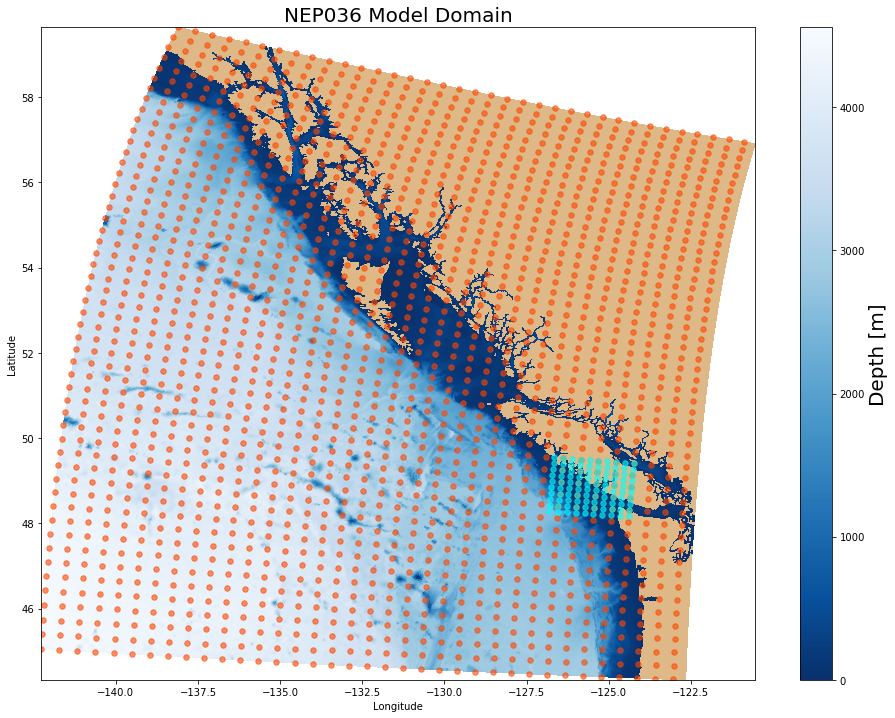

In [2]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry'][:]


# grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Blues_r')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
p = ax.pcolormesh(lon, lat, z0, cmap=cmap, vmin=0)#, vmax=500)
n=20
n1 = 10
ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
ax.scatter(lon[250:350:n1,550:650:n1], lat[250:350:n1,550:650:n1], c='cyan', s=30, alpha=0.6)
ax.set_xlim([lon.min(), lon.max()])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_ylim([lat.min(), lat.max()])
ax.set_title('NEP036 Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, color='burlywood')
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
# plt.savefig('domain.png')

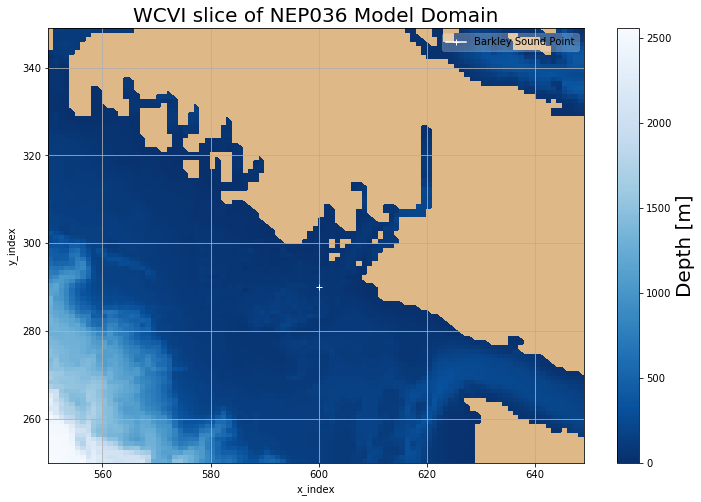

In [3]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

# Z = bathy.variables['Bathymetry'][y_wcvi_slice,x_wcvi_slice]
Z = bathy.variables['Bathymetry']

y_wcvi_slice = np.arange(250,350)
x_wcvi_slice = np.arange(550,650)

# grid = nc.Dataset('/ocean/ssahu/CANYONS/wcvi/grid/coordinates_NEMO/coordinates_westcoast_seagrid_high_resolution_truncated_wider_west_bdy.nc')


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

# z0 = np.ma.masked_values(Z, 0)
# plt.plot(lon[::10,::10],lat[::10,::10],'m.')
cmap = plt.get_cmap('Blues_r')
# cmap.set_bad('gainsboro')
# cmap = cmo.cm.deep
cmap.set_bad('burlywood')
fig, ax = plt.subplots(1, 1, figsize=(12,8)); ax.grid()
p = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)#, vmax=500)
ax.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = ax.legend(loc='best', fancybox=True, framealpha=0.25)
n=20
n1 = 10
# ax.scatter(lon[::n,::n], lat[::n,::n], c='orangered', s=30, alpha=0.6)
# ax.scatter(lon[270:350:n1,550:650:n1], lat[270:350:n1,550:650:n1], c='cyan', s=30, alpha=0.6)
# ax.set_xlim([lon[270:350,550:650].min(), lon[270:350,550:650].max()])
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')
# ax.set_ylim([lat[270:350,550:650].min(), lat[270:350,550:650].max()])
ax.set_title('WCVI slice of NEP036 Model Domain', fontsize=20)
viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
# viz_tools.plot_coastline(ax, bathymetry=bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice)
# plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')
# plt.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left='off',      # ticks along the bottom edge are off
#     labelleft='off')
cbar = fig.colorbar(p, ax=ax)
cbar.ax.set_ylabel('Depth [m]', fontsize=20)
ax.grid()
# plt.savefig('domain.png')

In [4]:
def tem_sal_timeseries_at_WCVI_locations(grid_scalar):#, j, i):
    
#     temp = grid_scalar.variables['votemper'][0,:, j, i]
#     sal = grid_scalar.variables['vosaline'][0,:, j, i]
    temp = grid_scalar.variables['votemper'][0,:, :, :]
    sal = grid_scalar.variables['vosaline'][0,:, :, :]
    
    scalar_ts = namedtuple('scalar_ts', 'temp, sal')

    return scalar_ts(temp, sal)

In [5]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict
# from datetime import (
#     datetime,
#     timedelta,
# )
# from resource import getrlimit, RLIMIT_NOFILE
import os

# import arrow
# import netCDF4 as nc
# import pandas as pd
# import numpy as np

# import warnings

# from salishsea_tools import hg_commands as hg

# temp_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
# sal_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))

temp_july = np.empty((31,50,Z.shape[0],Z.shape[1]))
sal_july = np.empty((31,50,Z.shape[0],Z.shape[1]))

i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_T.nc')):
#     if fnmatch.fnmatch(file, '*_orig.nc') == False:
#         if fnmatch.fnmatch(file, '*ops_y2015m12d15.nc') == False:
        
#     if file != 'results/forcing/atmospheric/GEM2.5/operational/ops_y2015m04d03_orig.nc':
#     scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file), y_wcvi_slice,x_wcvi_slice)
    scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file))
#             uwind_es = np.append(uwind_es , wind_ts_es[0])
    temp_july[i,...] = scalar_ts[0]
    sal_july[i,...] = scalar_ts[1]
    i = i+1
#     else:
#         continue


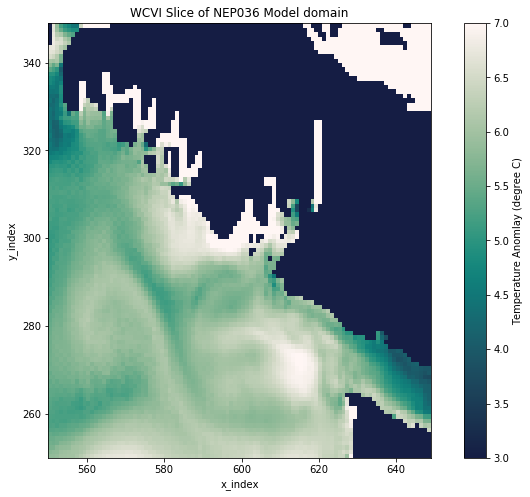

In [6]:
# temp0 = np.ma.masked_values(temp_july[0,0,....], 0)  #for higher accuracy masking should always be done from bathymetry and not from ssh data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650]- np.nanmean(temp_july[0,0,...]), cmap=cmap, vmin = 3, vmax = 7)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Temperature Anomlay (degree C)')
ax.set_title("WCVI Slice of NEP036 Model domain")
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

### (Warmer or colder ?) eddy core visible from the temperature anomaly of the surface plot 

### Q. 1) How deep does it extend below the surface ? (Let us analyse the vertical slice at (270,600)

### Q. 2) When does it appear (What time of the year : yet to be answered: make video of plots) ?

### Q. 3) Does the location of the eddy change with time ?

### Q. 4 ) Confirm it is an eddy from the surface plot of the currents near this region.

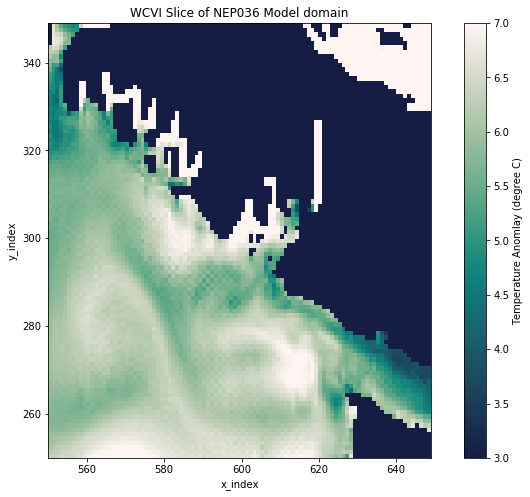

In [7]:
# temp0 = np.ma.masked_values(temp_july[0,0,....], 0)  #for higher accuracy masking should always be done from bathymetry and not from ssh data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,2,250:350,550:650]- np.nanmean(temp_july[0,6,...]), cmap=cmap, vmin = 3, vmax = 7)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Temperature Anomlay (degree C)')
ax.set_title("WCVI Slice of NEP036 Model domain")
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

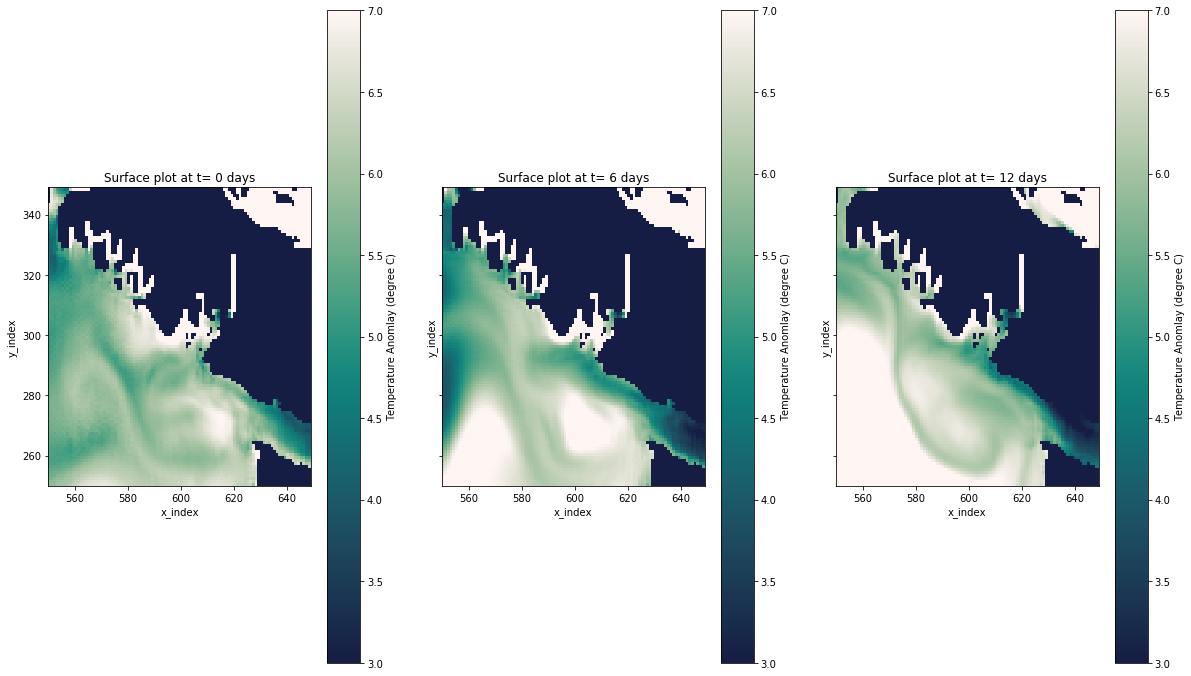

In [8]:
fig, axs = plt.subplots(1, 3,  figsize=(20, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')

time_steps = (0, 6, 12)
for ax, t in zip(axs, time_steps):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[t,0,250:350,550:650]- np.nanmean(temp_july[t,0,...]), cmap=cmap, vmin = 3, vmax = 7)
    viz_tools.set_aspect(ax)
    ax.set_title('Surface plot at t= {0} days'.format(t))
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Temperature Anomlay (degree C)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')

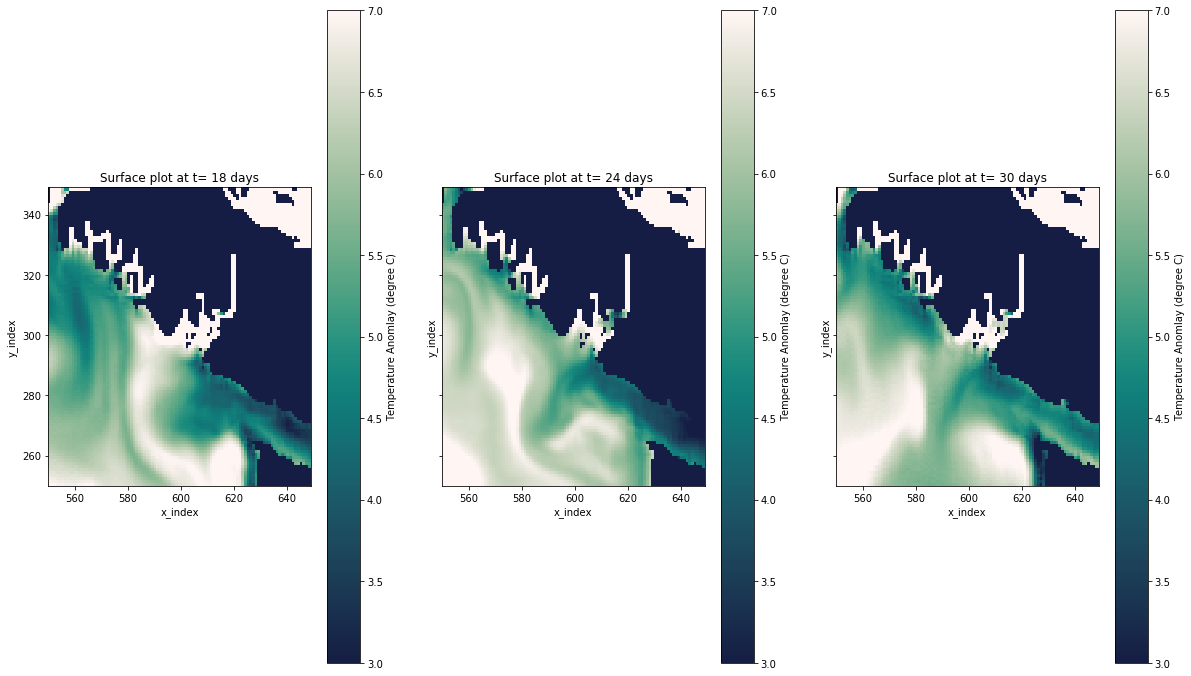

In [9]:
fig, axs = plt.subplots(1, 3,  figsize=(20, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')

time_steps = (18, 24, 30)
for ax, t in zip(axs, time_steps):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[t,0,250:350,550:650]- np.nanmean(temp_july[t,0,...]), cmap=cmap, vmin = 3, vmax = 7)
    viz_tools.set_aspect(ax)
    ax.set_title('Surface plot at t= {0} days'.format(t))
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Temperature Anomlay (degree C)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')

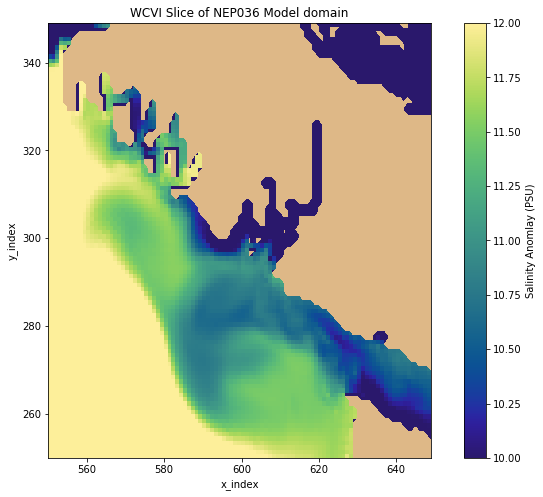

In [10]:

# temp0 = np.ma.masked_values(temp_july[0,0,....], 0)  #for higher accuracy masking should always be done from bathymetry and not from ssh data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[0,0,250:350,550:650]- np.nanmean(sal_july[0,0,...]), cmap=cmap, vmin = 10, vmax = 12)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("WCVI Slice of NEP036 Model domain")
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

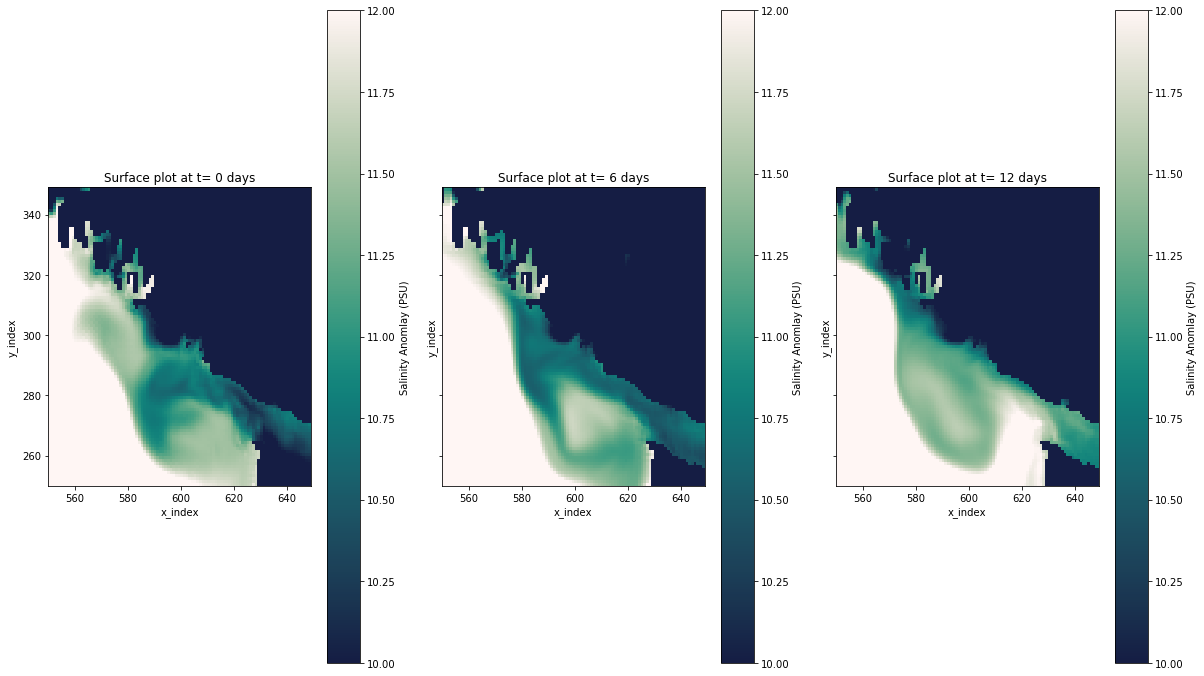

In [11]:
fig, axs = plt.subplots(1, 3,  figsize=(20, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')

time_steps = (0, 6, 12)
for ax, t in zip(axs, time_steps):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,0,250:350,550:650]- np.nanmean(sal_july[t,0,...]), cmap=cmap, vmin = 10, vmax = 12)
    viz_tools.set_aspect(ax)
    ax.set_title('Surface plot at t= {0} days'.format(t))
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Salinity Anomlay (PSU)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')

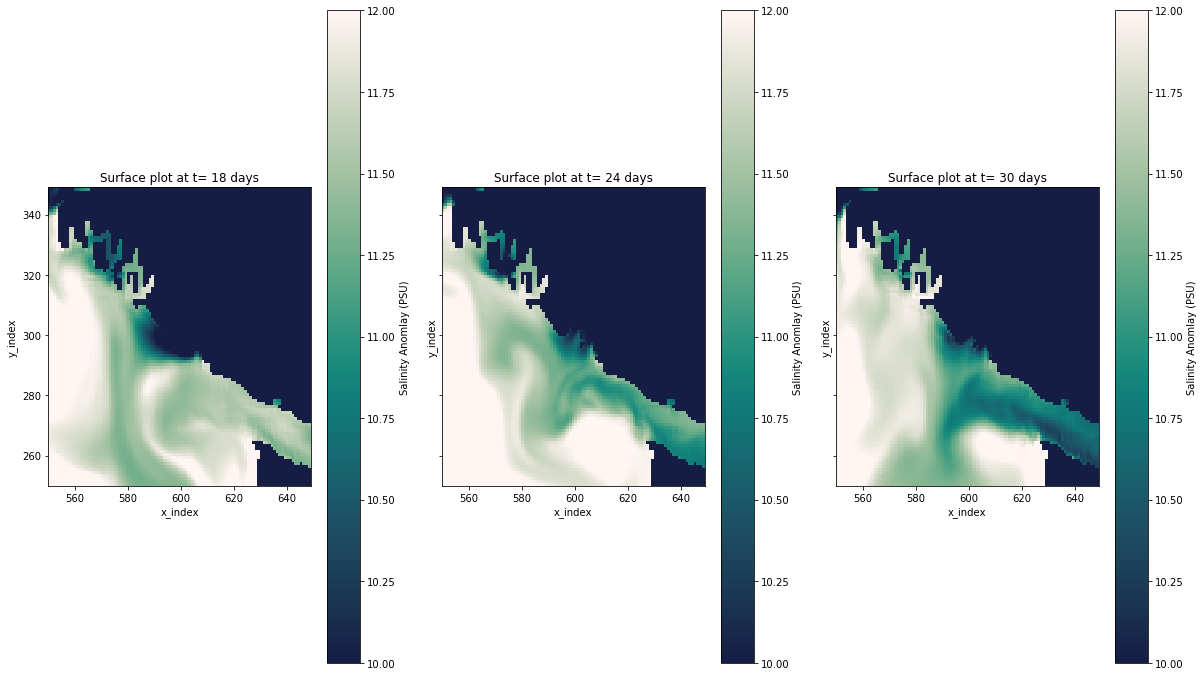

In [12]:
fig, axs = plt.subplots(1, 3,  figsize=(20, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')

time_steps = (18, 24, 30)
for ax, t in zip(axs, time_steps):
    mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[t,0,250:350,550:650]- np.nanmean(sal_july[t,0,...]), cmap=cmap, vmin = 10, vmax = 12)
    viz_tools.set_aspect(ax)
    ax.set_title('Surface plot at t= {0} days'.format(t))
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label('Salinity Anomlay (PSU)')
    ax.set_xlabel('x_index')
    ax.set_ylabel('y_index')

### Q) Do we see the impact of the VICC (or the columbia river plume highly unlikely) later on in the month ? WHy does the eddy get mixed in the surface ? Or is it the action of the local winds directed differently ? See from the whole plot (Impact of the plume or not ? or check the winds in the domain from WCVI plots)  [TO BE DONE LATER]

In [13]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht']

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


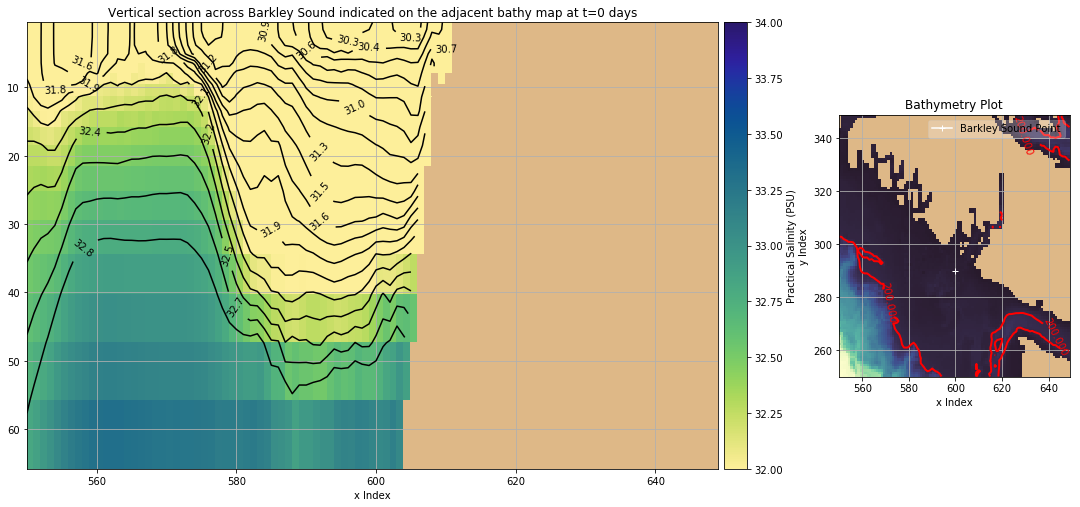

In [14]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 0 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:20])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


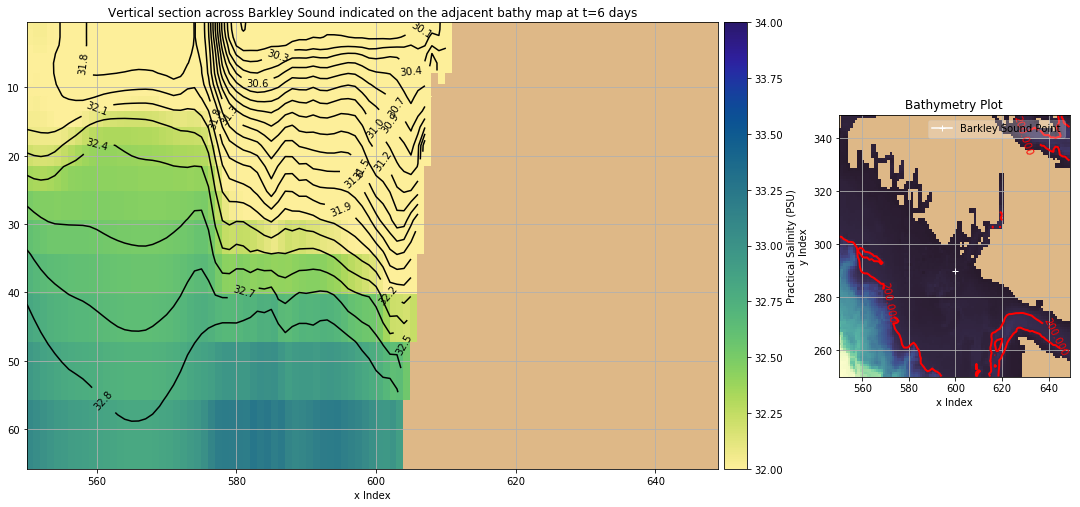

In [15]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 6 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:20])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


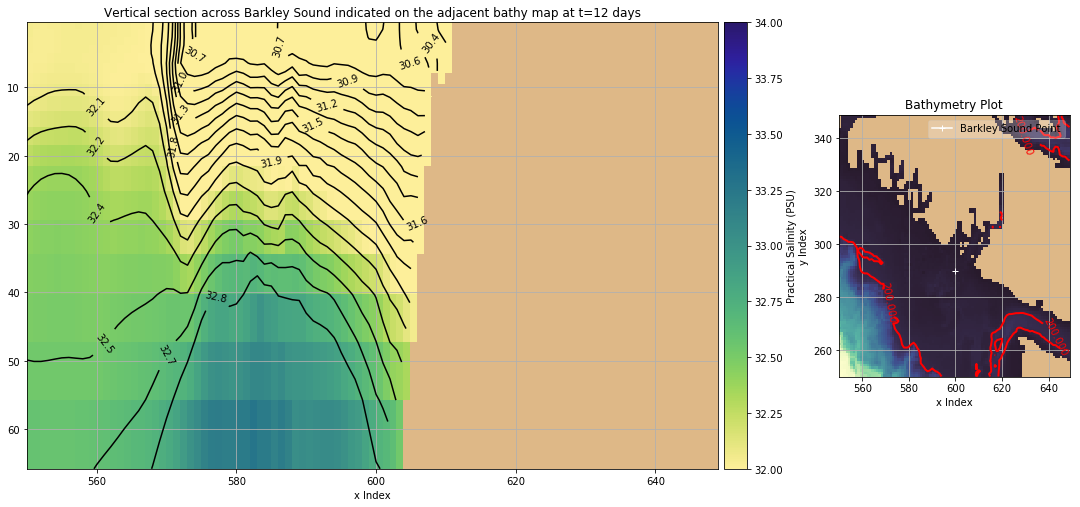

In [16]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:20])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


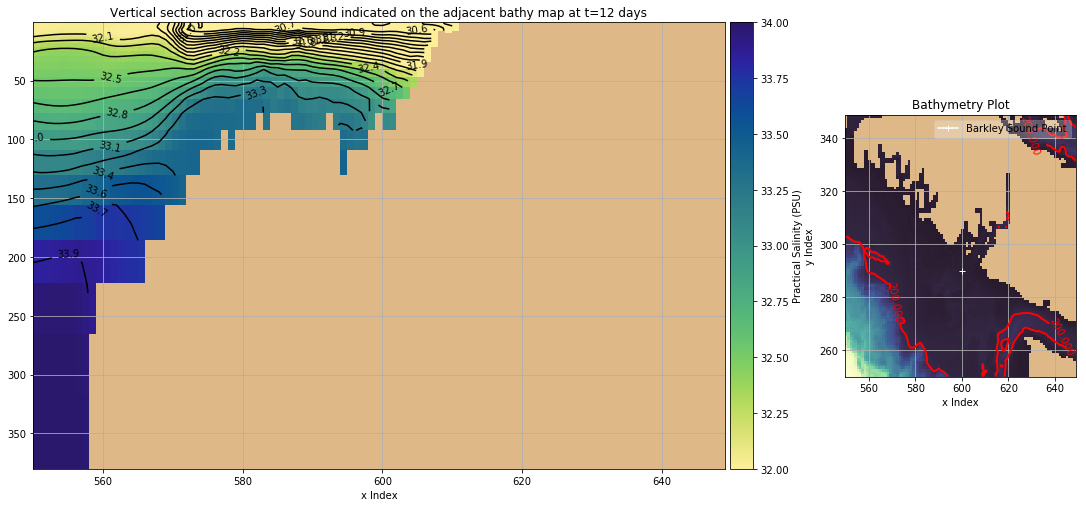

In [17]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 12 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :30, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:30])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:30], sal_tzyx[:30,290,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:30], sal_tzyx[:30,290,x_wcvi_slice], np.arange(30, 35, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


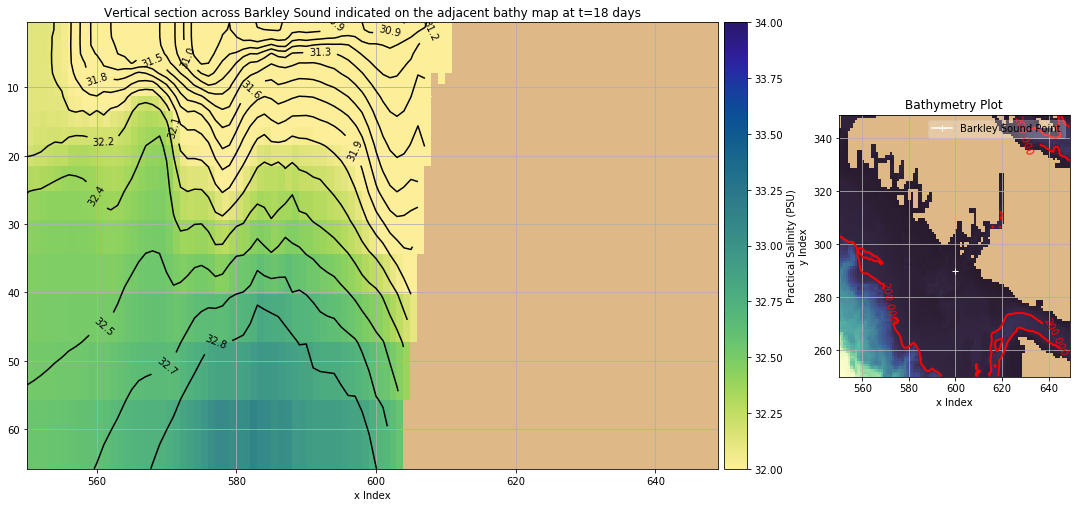

In [18]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# bathy = bathymetry
# x_slice = np.arange(bathy.shape[1])
# y_slice = np.arange(bathy.shape[0])
axr.pcolormesh(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap, vmin=0)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()

# Plot 24h average salinity at all depths along thalweg line
t = 18 
cmap = plt.get_cmap(cmo.cm.haline_r)
cmap.set_bad(land_colour)
sal_0 = sal_july[t, :20, :,:]
sal_tzyx = np.ma.masked_values(sal_0, 0)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:20])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], cmap=cmap, vmin=32, vmax=34)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Practical Salinity (PSU)')
clines = axl.contour(x_wcvi_slice, zlevels[:20], sal_tzyx[:20,290,x_wcvi_slice], np.arange(30, 33, 0.15), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound indicated on the adjacent bathy map at t={0} days'.format(t))

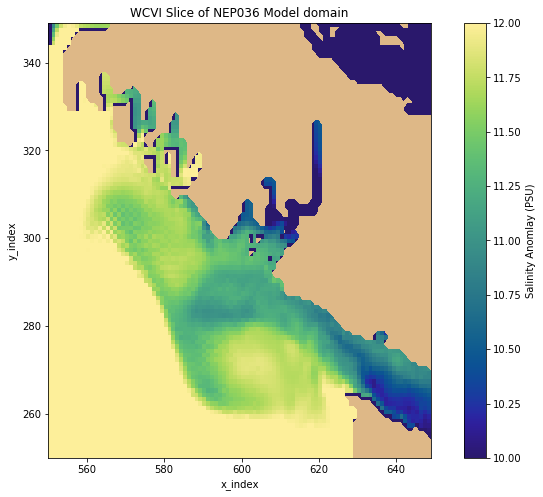

In [19]:
# temp0 = np.ma.masked_values(temp_july[0,0,....], 0)  #for higher accuracy masking should always be done from bathymetry and not from ssh data
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(temp0)
cmap = plt.get_cmap(cmo.cm.haline)
cmap.set_bad('burlywood')
mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,sal_july[0,5,250:350,550:650]- np.nanmean(sal_july[0,5,...]), cmap=cmap, vmin = 10, vmax = 12)
# mesh = ax.pcolormesh(x_wcvi_slice,y_wcvi_slice,temp_july[0,0,250:350,550:650], cmap=cmap, vmin = 12, vmax = 15)
cbar = fig.colorbar(mesh)
cbar.set_label('Salinity Anomlay (PSU)')
viz_tools.plot_land_mask(ax, bathy, xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
ax.set_title("WCVI Slice of NEP036 Model domain")
ax.set_xlabel('x_index')
ax.set_ylabel('y_index')

In [4]:
def U_timeseries_at_WCVI_locations(grid_U):
    u_vel = grid_U.variables['vozocrtx'][0,:, :, :]
    
    vector_u = namedtuple('vector_u', 'u_vel')

    return vector_u(u_vel)


def V_timeseries_at_WCVI_locations(grid_V):
    
    v_vel = grid_V.variables['vomecrty'][0,:, :, :]
    
    vector_v = namedtuple('vector_v', 'v_vel')

    return vector_v(v_vel)

In [ ]:
from __future__ import division
import glob
import os
import fnmatch
from collections import namedtuple, OrderedDict
# from datetime import (
#     datetime,
#     timedelta,
# )
# from resource import getrlimit, RLIMIT_NOFILE
import os

# import arrow
# import netCDF4 as nc
# import pandas as pd
# import numpy as np

# import warnings

# from salishsea_tools import hg_commands as hg

# temp_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))
# sal_july = np.empty((31,50,y_wcvi_slice.shape[0],x_wcvi_slice.shape[0]))

u_july = np.empty((31,50,Z.shape[0],Z.shape[1]))
v_july = np.empty((31,50,Z.shape[0],Z.shape[1]))

i = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_U.nc')):
#     if fnmatch.fnmatch(file, '*_orig.nc') == False:
#         if fnmatch.fnmatch(file, '*ops_y2015m12d15.nc') == False:
        
#     if file != 'results/forcing/atmospheric/GEM2.5/operational/ops_y2015m04d03_orig.nc':
#     scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file), y_wcvi_slice,x_wcvi_slice)
    vector_u = U_timeseries_at_WCVI_locations(nc.Dataset(file))
#             uwind_es = np.append(uwind_es , wind_ts_es[0])
    u_july[i,...] = vector_u[0]
    i = i+1
#     else:
#         continue




j = 0
for file in sorted(glob.glob('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_201507*grid_V.nc')):
#     if fnmatch.fnmatch(file, '*_orig.nc') == False:
#         if fnmatch.fnmatch(file, '*ops_y2015m12d15.nc') == False:
        
#     if file != 'results/forcing/atmospheric/GEM2.5/operational/ops_y2015m04d03_orig.nc':
#     scalar_ts = tem_sal_timeseries_at_WCVI_locations(nc.Dataset(file), y_wcvi_slice,x_wcvi_slice)
    vector_v = V_timeseries_at_WCVI_locations(nc.Dataset(file))
#             uwind_es = np.append(uwind_es , wind_ts_es[0])
    v_july[j,...] = vector_v[0]
    j = j+1

In [31]:
    
    
    
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20150710_00430560_grid_U.nc').variables['depthu']

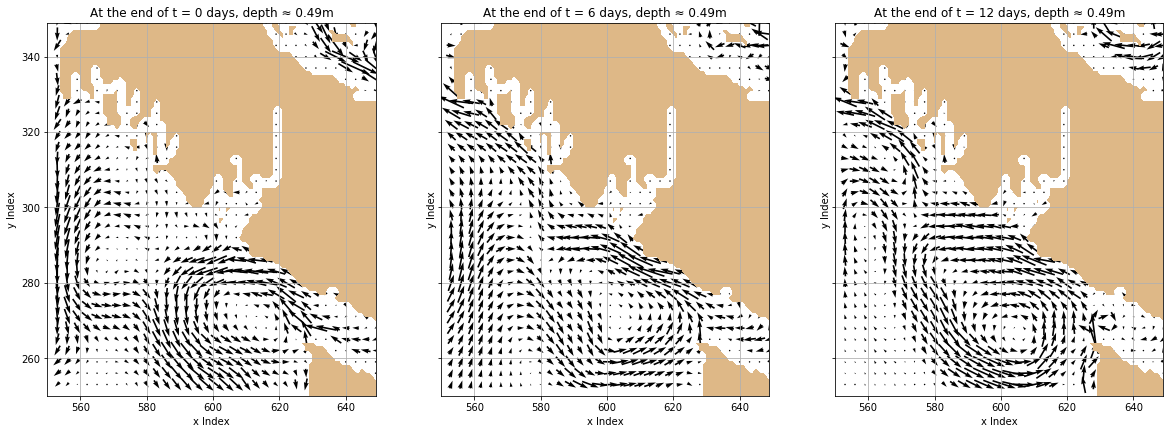

In [38]:


# Define the slice to plot
t  = (0, 6, 12)
zlevel = 0

# Slice and mask the arrays
# ugrid_tzyx = np.ma.masked_values(u_july[t, zlevel, y_wcvi_slice, x_wcvi_slice], 0)
# vgrid_tzyx = np.ma.masked_values(v_july[t, zlevel, y_wcvi_slice, x_wcvi_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points



arrow_step = 3
y_slice_a = y_wcvi_slice[::arrow_step]
x_slice_a = x_wcvi_slice[::arrow_step]


fig, axs = plt.subplots(1, 3,  figsize=(20, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')


for ax, t in zip(axs, t):
    u_tzyx, v_tzyx = viz_tools.unstagger(u_july[t,zlevel,250:350,550:650], v_july[t,zlevel,250:350,550:650])
    speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
    
    viz_tools.set_aspect(ax)
    quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
    viz_tools.plot_land_mask(ax, bathy , xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
    # Axes limits and grid
    ax.set_xlim(x_wcvi_slice[0], x_wcvi_slice[-1])
    ax.set_ylim(y_wcvi_slice[0], y_wcvi_slice[-1])
    ax.grid()
    # Axes label and title
    ax.set_xlabel('x Index')
    ax.set_ylabel('y Index')
    ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format(t, d=zlevels[zlevel], z=zlevels))
    ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')


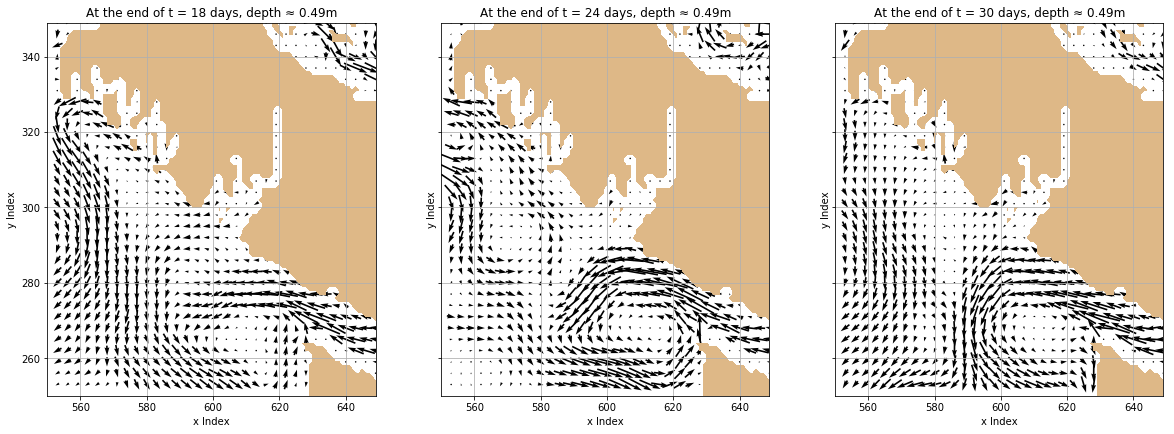

In [39]:


# Define the slice to plot
t  = (18, 24, 30)
zlevel = 0

# Slice and mask the arrays
# ugrid_tzyx = np.ma.masked_values(u_july[t, zlevel, y_wcvi_slice, x_wcvi_slice], 0)
# vgrid_tzyx = np.ma.masked_values(v_july[t, zlevel, y_wcvi_slice, x_wcvi_slice], 0)
# "Unstagger" the velocity values by interpolating them to the T-grid points



arrow_step = 3
y_slice_a = y_wcvi_slice[::arrow_step]
x_slice_a = x_wcvi_slice[::arrow_step]


fig, axs = plt.subplots(1, 3,  figsize=(20, 12), sharey=True)
cmap = plt.get_cmap(cmo.cm.tempo_r)
cmap.set_bad('burlywood')


for ax, t in zip(axs, t):
    u_tzyx, v_tzyx = viz_tools.unstagger(u_july[t,zlevel,250:350,550:650], v_july[t,zlevel,250:350,550:650])
    speeds = np.sqrt(np.square(u_tzyx) + np.square(v_tzyx))
    
    viz_tools.set_aspect(ax)
    quiver = ax.quiver(x_slice_a[1:], y_slice_a[1:], u_tzyx[::3,::3], v_tzyx[::3,::3] ,pivot='mid', cmap='Reds', width=0.005)
    viz_tools.plot_land_mask(ax, bathy , xslice=x_wcvi_slice, yslice=y_wcvi_slice, color='burlywood')
    # Axes limits and grid
    ax.set_xlim(x_wcvi_slice[0], x_wcvi_slice[-1])
    ax.set_ylim(y_wcvi_slice[0], y_wcvi_slice[-1])
    ax.grid()
    # Axes label and title
    ax.set_xlabel('x Index')
    ax.set_ylabel('y Index')
    ax.set_title('At the end of t = {0} days, depth \u2248 {d:.2f}{z.units}'.format(t, d=zlevels[zlevel], z=zlevels))
    ax.quiverkey(quiver, 65, 55, 0.5, '0.5 m/s', coordinates='data', color='blue', labelcolor='blue')


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


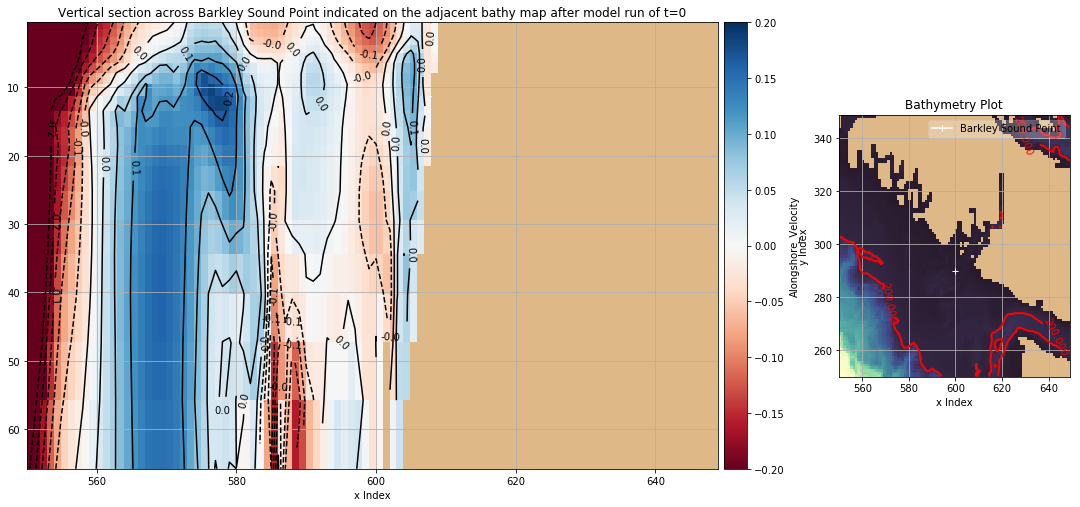

In [50]:
# Set up the figure and axes
fig, (axl, axcb, axr) = plt.subplots(1, 3, figsize=(16, 8))
land_colour = 'burlywood'
for ax in (axl, axr):
    ax.set_axis_bgcolor(land_colour)
axl.set_position((0.125, 0.125, 0.6, 0.775))
axcb.set_position((0.73, 0.125, 0.02, 0.775))
axr.set_position((0.83, 0.125, 0.2, 0.775))

# Plot thalweg points on bathymetry map
viz_tools.set_aspect(axr)
cmap = plt.get_cmap(cmo.cm.deep_r)
cmap.set_bad(land_colour)
# # bathymetry = bathy
# x_slice = np.arange(Z.shape[1])
# y_slice = np.arange(Z.shape[0])
axr.pcolormesh(x_wcvi_slice, y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], cmap=cmap)
axr.plot(
    600, 290,
    linestyle='-', marker='+', color='white',
    label='Barkley Sound Point',
)
legend = axr.legend(loc='best', fancybox=True, framealpha=0.25)
axr.set_title('Bathymetry Plot')
axr.set_xlabel('x Index')
axr.set_ylabel('y Index')
CS = axr.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], levels = [200],
                 colors=('red',),linestyles=('-',),linewidths=(2,))


axr.clabel(CS)
axr.grid()



# Plot 24h average salinity at all depths along thalweg line
t = 0 

v_0 = v_july[t, :, :,:]
v_masked = np.ma.masked_values(v_0, 0)



cmap = plt.cm.get_cmap('RdBu')
cmap.set_bad(land_colour)
x, z = np.meshgrid(x_wcvi_slice, zlevels[:20])
mesh = axl.pcolormesh(x_wcvi_slice, zlevels[:20], v_masked[:20,290,x_wcvi_slice], cmap=cmap, vmin = -0.2, vmax = 0.2)
cbar = plt.colorbar(mesh, cax=axcb)
cbar.set_label('Alongshore_Velocity')
clines = axl.contour(x_wcvi_slice, zlevels[:20], v_masked[:20,290,x_wcvi_slice], np.arange(-0.2, 0.2, 0.04), colors='black')
axl.clabel(clines, fmt='%1.1f', inline=True)
axl.invert_yaxis()
axl.set_xlabel('x Index')
# axl.set_ylabel('{0.long_name} [{0.units}]'.format(zlevels))
axl.grid()
axl.set_title('Vertical section across Barkley Sound Point indicated on the adjacent bathy map after model run of t={0}'.format(t))

In [22]:
y_wcvi_slice.shape

(100,)

In [23]:
x_wcvi_slice.shape

(100,)

0.49402538